In [12]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

print("Auto-reload enabled! Your scripts will be automatically reloaded when you change them.")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Auto-reload enabled! Your scripts will be automatically reloaded when you change them.


In [13]:
# Decentralized Learning with ByzFL Pattern
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Import ByzFL components
from byzfl.fed_framework import Client, Server, ByzantineClient, DataDistributor
from byzfl.utils.misc import set_random_seed

# Import our decentralized components
from graph import build_graph_G, build_metropolis_W, analyze_network


In [14]:
# Data Preparation from MNIST
from typing import Any


from torchvision import datasets, transforms
from torch import Tensor

# Data preparation following ByzFL pattern
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_dataset.targets = Tensor(train_dataset.targets).long()  # Required for ByzFL
train_loader = DataLoader(train_dataset, shuffle=True)



print(f"MNIST Dataset loaded:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Image shape: {train_dataset[0][0].shape}")
print(f"- Number of classes: {len(torch.unique(train_dataset.targets))}")
print(f"- Class distribution: {torch.bincount(train_dataset.targets)}")


MNIST Dataset loaded:
- Training samples: 60000
- Image shape: torch.Size([1, 28, 28])
- Number of classes: 10
- Class distribution: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


In [21]:
# Set random seed for reproducibility
SEED = 42
set_random_seed(SEED)

# Decentralized Learning Configurations
nb_nodes = 6
nb_training_steps = 10
batch_size = 32
convergence_threshold = 1e-4


In [16]:
# Prepare Test Dataset
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_dataset.targets = Tensor(test_dataset.targets).long() # Required for Datasets that targets are not Tensor (e.g. CIFAR-10)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:

# Choose model - cnn_mnist is most appropriate for MNIST images
model_name = "cnn_mnist"  # Changed to CNN for better MNIST performance
print(f"\nUsing ByzFL model: {model_name}")

# Test the model
import byzfl.fed_framework.models as models
test_model = getattr(models, model_name)()
print(f"Model parameters: {sum(p.numel() for p in test_model.parameters())}")
print(f"Model structure: {test_model}")

# Test with a sample MNIST image
sample_image, sample_label = train_dataset[0]
print(f"\nSample MNIST image:")
print(f"- Image shape: {sample_image.shape}")
print(f"- Label: {sample_label}")
print(f"- Model output shape: {test_model(sample_image.unsqueeze(0)).shape}")



Using ByzFL model: cnn_mnist
Model parameters: 431080
Model structure: cnn_mnist(
  (_c1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (_c2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (_f1): Linear(in_features=800, out_features=500, bias=True)
  (_f2): Linear(in_features=500, out_features=10, bias=True)
)

Sample MNIST image:
- Image shape: torch.Size([1, 28, 28])
- Label: 5
- Model output shape: torch.Size([1, 10])


In [18]:
# Distribute MNIST data among nodes using ByzFL DataDistributor
data_distributor = DataDistributor({
    "data_distribution_name": "dirichlet_niid",
    "distribution_parameter": 0.5,
    "nb_honest": nb_nodes,
    "data_loader": train_loader,
    "batch_size": batch_size,
})
node_dataloaders = data_distributor.split_data()


In [19]:
# Create decentralized nodes following ByzFL pattern with MNIST
decentralized_nodes = []

for i in range(nb_nodes):
    # Create node parameters following ByzFL Client pattern
    node_params = {
        "model_name": model_name,  # Use ByzFL's cnn_mnist model
        "device": "cpu",
        "optimizer_name": "SGD",
        "learning_rate": 0.1,
        "weight_decay": 0.0001,  # Typical for MNIST
        "milestones": [100, 200],
        "learning_rate_decay": 0.25,
        "loss_name": "NLLLoss",  # Changed back to NLLLoss for cnn_mnist (uses log_softmax)
        "LabelFlipping": False,
        "training_dataloader": node_dataloaders[i],
        "momentum": 0.9,
        "nb_labels": 10,  # MNIST has 10 classes
        "store_per_client_metrics": True,
        # Decentralized specific parameters
        "node_id": i,
        "neighbors": [],  # Will be set by network manager
        "mixing_row": [],  # Will be set by network manager
        "degree": 0,  # Will be set by network manager
        "convergence_threshold": convergence_threshold,
        "max_rounds": nb_training_steps,
        # Server-like parameters for aggregation
        "aggregator_info": {"name": "Average", "parameters": {}},
        "pre_agg_list": [],
        "test_loader": test_loader,  
    }
    
    # Create node
    from node import Node
    node = Node(node_params)
    decentralized_nodes.append(node)

print(f"Created {len(decentralized_nodes)} decentralized nodes using ByzFL's {model_name} model")
print("Ready for decentralized learning with real MNIST data!")


Created 6 decentralized nodes using ByzFL's cnn_mnist model
Ready for decentralized learning with real MNIST data!


In [20]:
# Create network topology and setup decentralized learning
print("Setting up decentralized network topology...")

# Dictionary for approximate number of edges based on graph type
# Formulas from graph theory: e ≈ edges, where n = number of nodes
# NOTE: Minimum edges for connected graph = n - 1 (tree topology)
# Maximum edges for simple graph = n * (n - 1) / 2 (complete graph)
num_edges = {
    'sparse': nb_nodes,                       # e ≈ n (ring/chain: slow mixing, light communication)
    'moderate': 2 * nb_nodes,                 # e ≈ 2n-3n (good balance: using 2n as representative)
    'dense': 5 * nb_nodes                     # e ≈ 5n-8n (fast convergence: using 5n as representative)
}

# Build graph and mixing matrix
# build_graph_G now takes (n, e, seed=None) where n=nodes, e=edges
# Choose graph type: 'sparse', 'moderate', or 'dense'
graph_type = 'moderate'  # Change to 'moderate' or 'dense' to use different graph types
graph = build_graph_G(nb_nodes, num_edges[graph_type], seed=42)
mixing_matrix = build_metropolis_W(graph)

# Analyze network
network_analysis = analyze_network(graph, mixing_matrix)

# Create network manager
from network_manager import NetworkManager
network_manager = NetworkManager(graph, mixing_matrix, decentralized_nodes)

# Update node topology information
for i, node in enumerate(decentralized_nodes):
    from graph import topology_view
    topology = topology_view(i, graph, mixing_matrix)
    node.neighbors = topology["neighbors"]
    node.mixing_row = topology["mixing_row"]
    node.degree = topology["degree"]

print(f"Network topology created:")
print(f"- Graph degree: {graph_degree}")
print(f"- Spectral gap: {network_analysis['spectral_gap']:.4f}")
print(f"- Node connections:")
for i, node in enumerate(decentralized_nodes):
    print(f"  Node {i}: neighbors = {node.neighbors}, degree = {node.degree}")


Setting up decentralized network topology...

=== Mixing matrix W checks ===
Row-stochastic: True
Row sums: min=1.000000000000 | max=1.000000000000

Nonzero entries of W (rows 0–4):
 row  col     W_ij
   0    0 0.233333
   0    1 0.200000
   0    2 0.200000
   0    3 0.166667
   0    5 0.200000
   1    0 0.200000
   1    1 0.233333
   1    3 0.166667
   1    4 0.200000
   1    5 0.200000
   2    0 0.200000
   2    2 0.433333
   2    3 0.166667
   2    4 0.200000
   3    0 0.166667
   3    1 0.166667
   3    2 0.166667
   3    3 0.166667
   3    4 0.166667
   3    5 0.166667

=== Spectral diagnostics (sorted by |λ|) ===
 idx   lambda_real  lambda_imag     |lambda|
   0  1.000000e+00          0.0 1.000000e+00
   1  4.333333e-01          0.0 4.333333e-01
   2  2.333333e-01          0.0 2.333333e-01
   3 -1.666667e-01          0.0 1.666667e-01
   4  3.333333e-02          0.0 3.333333e-02
   5  9.292103e-17          0.0 9.292103e-17

λ1 (should be ~1): 1.000000000000 (abs=1.000000000000)
|λ

In [22]:
# Initialize all nodes with the same model (following ByzFL pattern)
print("Initializing nodes with shared model...")

# Get initial model from first node
initial_model = decentralized_nodes[0].get_dict_parameters()

# Send initial model to all nodes
for node in decentralized_nodes:
    node.set_model_state(initial_model)

print("All nodes initialized with shared model")

# Training Loop following ByzFL pattern
print("\nStarting Decentralized Learning Training Loop...")
print("=" * 60)

training_results = []

for training_step in range(nb_training_steps):
    
    # Evaluate Global Model Every 20 Training Steps
    if training_step % 20 == 0:
        # Compute average test accuracy across all nodes
        test_accuracies = []
        for node in decentralized_nodes:
            try:
                acc = node.compute_test_accuracy()
                test_accuracies.append(acc)
            except:
                test_accuracies.append(0.0)
        
        avg_test_acc = np.mean(test_accuracies) if test_accuracies else 0.0
        print(f"--- Training Step {training_step}/{nb_training_steps} ---")
        print(f"Average Test Accuracy: {avg_test_acc:.4f}")
        
        # DEBUG: Print loss per node to verify each node trains on different data
        print(f"\nDEBUG: Loss per node at step {training_step}:")
        for node_id in sorted(network_manager.nodes.keys()):
            node = network_manager.nodes[node_id]
            if node.get_loss_list():
                current_loss = node.get_loss_list()[-1]
                print(f"  Node {node_id} loss: {current_loss:.4f}")
    
    # Perform decentralized learning round
    round_result = network_manager.perform_decentralized_round()
    training_results.append(round_result)
    
    # Check for convergence
    if round_result['global_converged']:
        print(f"\nConverged after {training_step + 1} steps!")
        break

print("\n" + "=" * 60)
print("Decentralized Learning Training Complete!")


Initializing nodes with shared model...
All nodes initialized with shared model

Starting Decentralized Learning Training Loop...
--- Training Step 0/10 ---
Average Test Accuracy: 0.0715

DEBUG: Loss per node at step 0:
DEBUG Round 0: Node 0 gradient norm: 0.15047813951969147
DEBUG Round 0: Node 1 gradient norm: 0.1713433712720871
DEBUG Round 0: Node 2 gradient norm: 0.17842698097229004
DEBUG Round 0: Node 3 gradient norm: 0.2130526900291443
DEBUG Round 0: Node 4 gradient norm: 0.21694761514663696
DEBUG Round 0: Node 5 gradient norm: 0.23836158215999603
DEBUG: Node 0 - New and old gradient collection methods match ✓
DEBUG: Node 1 - New and old gradient collection methods match ✓
DEBUG: Node 2 - New and old gradient collection methods match ✓
DEBUG: Node 3 - New and old gradient collection methods match ✓
DEBUG: Node 4 - New and old gradient collection methods match ✓
DEBUG: Node 5 - New and old gradient collection methods match ✓

Decentralized Learning Training Complete!



Training Analysis:
- Total steps completed: 300
- Final convergence status: False


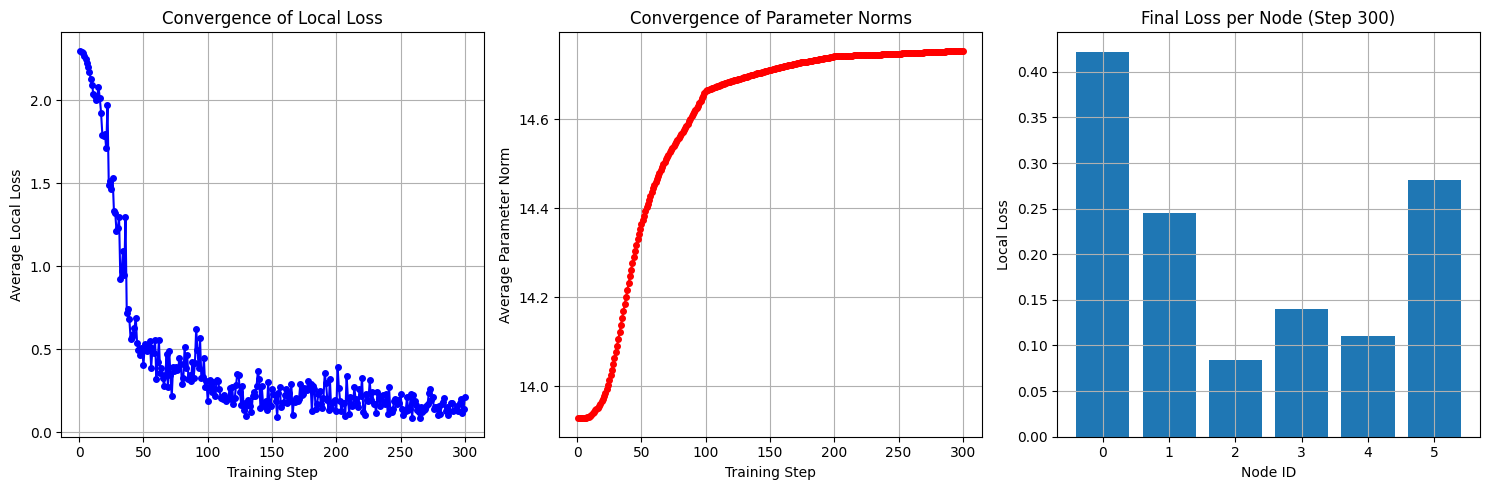


Decentralized Learning Experiment Complete!
This demonstrates core communication and gossip-based aggregation following ByzFL patterns.


In [11]:
# Analyze and visualize results
print(f"\nTraining Analysis:")
print(f"- Total steps completed: {len(training_results)}")
print(f"- Final convergence status: {training_results[-1]['global_converged']}")

# Extract metrics for plotting
steps = [r['round'] for r in training_results]
avg_losses = [np.mean([node_result['local_loss'] for node_result in r['node_results'].values()]) 
              for r in training_results]
avg_param_norms = [np.mean([node_result['parameter_norm'] for node_result in r['node_results'].values()]) 
                   for r in training_results]

# Plot convergence
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(steps, avg_losses, 'b-o', markersize=4)
plt.xlabel('Training Step')
plt.ylabel('Average Local Loss')
plt.title('Convergence of Local Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(steps, avg_param_norms, 'r-o', markersize=4)
plt.xlabel('Training Step')
plt.ylabel('Average Parameter Norm')
plt.title('Convergence of Parameter Norms')
plt.grid(True)

plt.subplot(1, 3, 3)
# Plot individual node losses for last few steps
if len(training_results) > 0:
    last_step_losses = [node_result['local_loss'] for node_result in training_results[-1]['node_results'].values()]
    plt.bar(range(len(last_step_losses)), last_step_losses)
    plt.xlabel('Node ID')
    plt.ylabel('Local Loss')
    plt.title(f'Final Loss per Node (Step {steps[-1]})')
    plt.grid(True)

plt.tight_layout()
plt.show()

print("\nDecentralized Learning Experiment Complete!")
print("This demonstrates core communication and gossip-based aggregation following ByzFL patterns.")
